### 데이터 셋업

In [15]:
# ======1단계: 입력 폴더 경로 설정
path_in = r"..\assets\ply\impeller\4wings"   # Windows 경로 예시
downsample_N = 1000         # 각각 포인트 샘플링 수


In [16]:
import os
import numpy as np
import open3d as o3d
from pathlib import Path

#======= 2단계: 단일 PLY 파일 → 점군으로 변환 후 .xyz 저장 =======
def convert_to_xyz(path_in: str, downsample_N: int = 1000):
    """
    단일 PLY 파일 → 점군으로 변환 후 .xyz 저장
    """
    mesh = o3d.io.read_triangle_mesh(path_in)
    if mesh.has_triangles():
        pcd = mesh.sample_points_poisson_disk(number_of_points=downsample_N)
    else:
        pcd = o3d.io.read_point_cloud(path_in)
        if len(pcd.points) > downsample_N:
            pts = np.asarray(pcd.points)
            idx = np.random.choice(len(pts), downsample_N, replace=False)
            pcd.points = o3d.utility.Vector3dVector(pts[idx])

    out_path = Path(path_in).with_name(Path(path_in).stem + "_point.xyz")
    np.savetxt(out_path, np.asarray(pcd.points), fmt="%.6f")
    print(f"[OK] {path_in} → {out_path} (N={len(pcd.points)})")


# 지정한 폴더에 있는 모든 .ply 파일 변환
folder = Path(path_in)
if not folder.is_dir():
    print(f"[ERR] 폴더 경로가 아님: {folder}")
else:
    ply_files = list(folder.glob("*.ply"))
    if not ply_files:
        print(f"[INFO] {folder} 안에 .ply 파일이 없습니다.")
    else:
        for ply in ply_files:
            convert_to_xyz(str(ply), downsample_N=downsample_N)
        print(f"[DONE] 총 {len(ply_files)} 개 파일 변환 완료.")


[OK] ..\assets\ply\impeller\4wings\imp001.ply → ..\assets\ply\impeller\4wings\imp001_point.xyz (N=1000)
[OK] ..\assets\ply\impeller\4wings\imp002.ply → ..\assets\ply\impeller\4wings\imp002_point.xyz (N=1000)
[OK] ..\assets\ply\impeller\4wings\imp003.ply → ..\assets\ply\impeller\4wings\imp003_point.xyz (N=1000)
[OK] ..\assets\ply\impeller\4wings\imp004.ply → ..\assets\ply\impeller\4wings\imp004_point.xyz (N=1000)
[OK] ..\assets\ply\impeller\4wings\imp005.ply → ..\assets\ply\impeller\4wings\imp005_point.xyz (N=1000)
[OK] ..\assets\ply\impeller\4wings\imp006.ply → ..\assets\ply\impeller\4wings\imp006_point.xyz (N=1000)
[OK] ..\assets\ply\impeller\4wings\imp007.ply → ..\assets\ply\impeller\4wings\imp007_point.xyz (N=1000)
[OK] ..\assets\ply\impeller\4wings\imp008.ply → ..\assets\ply\impeller\4wings\imp008_point.xyz (N=1000)
[OK] ..\assets\ply\impeller\4wings\imp009.ply → ..\assets\ply\impeller\4wings\imp009_point.xyz (N=1000)
[OK] ..\assets\ply\impeller\4wings\imp010.ply → ..\assets\ply\im

In [17]:
import numpy as np
import re
from pathlib import Path

# ====== 3단계: .xyz 파일 → .xyzc 파일로 변환 ======
def convert_xyz_to_xyzc(xyz_path: Path):
    """
    파일명에서 '마지막 숫자 묶음'을 라벨로 사용 → .xyzc 저장
    예:
      impeller_b3_010_point.xyz -> 라벨 10.00000000
      imp001_point.xyz          -> 라벨 1.00000000
    """
    stem = xyz_path.stem  # 예: 'imp001_point', 'impeller_b3_010_point'
    nums = re.findall(r'\d+', stem)
    if not nums:
        print(f"[SKIP] 라벨 숫자 추출 실패: {xyz_path.name}")
        return None

    # 마지막 숫자 블록 사용 (b3 같은 중간 숫자 회피)
    label_value = float(nums[-1])  # "010" -> 10.0, "001" -> 1.0

    # xyz 불러오기
    xyz = np.loadtxt(xyz_path)
    if xyz.ndim == 1:
        xyz = xyz.reshape(-1, 3)

    # 라벨 추가
    label_column = np.full((xyz.shape[0], 1), label_value, dtype=float)
    xyzc = np.hstack((xyz, label_column))

    # 저장
    out_path = xyz_path.with_suffix(".xyzc")
    np.savetxt(out_path, xyzc, fmt="%.6f %.6f %.6f %.8f")
    print(f"[OK] {xyz_path.name} → {out_path.name} (label={label_value:.8f})")
    return out_path

# ====== 폴더 내 모든 *_point.xyz 파일 처리 ======
folder = Path(path_in)
xyz_files = list(folder.glob("*_point.xyz"))

if not xyz_files:
    print(f"[INFO] {folder} 안에 '_point.xyz' 파일이 없습니다.")
else:
    ok, skip = 0, 0
    for xyz_file in xyz_files:
        outp = convert_xyz_to_xyzc(xyz_file)
        if outp is None:
            skip += 1
        else:
            ok += 1
    print(f"[DONE] 총 {len(xyz_files)}개 파일 중 변환 성공 {ok}개, 스킵 {skip}개.")


[OK] imp001_point.xyz → imp001_point.xyzc (label=1.00000000)
[OK] imp002_point.xyz → imp002_point.xyzc (label=2.00000000)
[OK] imp003_point.xyz → imp003_point.xyzc (label=3.00000000)
[OK] imp004_point.xyz → imp004_point.xyzc (label=4.00000000)
[OK] imp005_point.xyz → imp005_point.xyzc (label=5.00000000)
[OK] imp006_point.xyz → imp006_point.xyzc (label=6.00000000)
[OK] imp007_point.xyz → imp007_point.xyzc (label=7.00000000)
[OK] imp008_point.xyz → imp008_point.xyzc (label=8.00000000)
[OK] imp009_point.xyz → imp009_point.xyzc (label=9.00000000)
[OK] imp010_point.xyz → imp010_point.xyzc (label=10.00000000)
[OK] imp011_point.xyz → imp011_point.xyzc (label=11.00000000)
[OK] imp012_point.xyz → imp012_point.xyzc (label=12.00000000)
[OK] imp013_point.xyz → imp013_point.xyzc (label=13.00000000)
[OK] imp014_point.xyz → imp014_point.xyzc (label=14.00000000)
[OK] imp015_point.xyz → imp015_point.xyzc (label=15.00000000)
[OK] imp016_point.xyz → imp016_point.xyzc (label=16.00000000)
[OK] imp017_point

In [18]:
import numpy as np
from pathlib import Path

# ====== 4단계: 모든 XYZC 파일 병합 ======

output_file = Path(path_in) / "merged_all.xyzc"  # 최종 합쳐진 파일명

# 폴더 내 모든 .xyzc 찾기
folder = Path(path_in)
xyzc_files = list(folder.glob("*.xyzc"))

if not xyzc_files:
    print(f"[INFO] {folder} 안에 .xyzc 파일이 없습니다.")
else:
    merged_data = []
    for f in xyzc_files:
        try:
            data = np.loadtxt(f)
            if data.ndim == 1:  # 한 줄짜리 방지
                data = data.reshape(1, -1)
            merged_data.append(data)
            print(f"[READ] {f.name} (N={len(data)})")
        except Exception as e:
            print(f"[ERR] {f.name} 불러오기 실패: {e}")

    if merged_data:
        merged_data = np.vstack(merged_data)
        np.savetxt(output_file, merged_data, fmt="%.6f %.6f %.6f %.8f")
        print(f"[DONE] {len(xyzc_files)} 개 파일 합침 → {output_file} (총 {len(merged_data)} 포인트)")
    else:
        print("[INFO] 합칠 데이터가 없습니다.")


[READ] imp001_point.xyzc (N=1000)
[READ] imp002_point.xyzc (N=1000)
[READ] imp003_point.xyzc (N=1000)
[READ] imp004_point.xyzc (N=1000)
[READ] imp005_point.xyzc (N=1000)
[READ] imp006_point.xyzc (N=1000)
[READ] imp007_point.xyzc (N=1000)
[READ] imp008_point.xyzc (N=1000)
[READ] imp009_point.xyzc (N=1000)
[READ] imp010_point.xyzc (N=1000)
[READ] imp011_point.xyzc (N=1000)
[READ] imp012_point.xyzc (N=1000)
[READ] imp013_point.xyzc (N=1000)
[READ] imp014_point.xyzc (N=1000)
[READ] imp015_point.xyzc (N=1000)
[READ] imp016_point.xyzc (N=1000)
[READ] imp017_point.xyzc (N=1000)
[READ] imp018_point.xyzc (N=1000)
[READ] imp019_point.xyzc (N=1000)
[READ] imp020_point.xyzc (N=1000)
[READ] imp021_point.xyzc (N=1000)
[READ] imp022_point.xyzc (N=1000)
[READ] imp023_point.xyzc (N=1000)
[READ] imp024_point.xyzc (N=1000)
[READ] imp025_point.xyzc (N=1000)
[READ] imp026_point.xyzc (N=1000)
[DONE] 26 개 파일 합침 → ..\assets\ply\impeller\4wings\merged_all.xyzc (총 26000 포인트)


📊 Layer distribution (by percentage):
  Layer 1.000000: 20000 points (3.85%)
  Layer 2.000000: 20000 points (3.85%)
  Layer 3.000000: 20000 points (3.85%)
  Layer 4.000000: 20000 points (3.85%)
  Layer 5.000000: 20000 points (3.85%)
  Layer 6.000000: 20000 points (3.85%)
  Layer 7.000000: 20000 points (3.85%)
  Layer 8.000000: 20000 points (3.85%)
  Layer 9.000000: 20000 points (3.85%)
  Layer 10.000000: 20000 points (3.85%)
  Layer 11.000000: 20000 points (3.85%)
  Layer 12.000000: 20000 points (3.85%)
  Layer 13.000000: 20000 points (3.85%)
  Layer 14.000000: 20000 points (3.85%)
  Layer 15.000000: 20000 points (3.85%)
  Layer 16.000000: 20000 points (3.85%)
  Layer 17.000000: 20000 points (3.85%)
  Layer 18.000000: 20000 points (3.85%)
  Layer 19.000000: 20000 points (3.85%)
  Layer 20.000000: 20000 points (3.85%)
  Layer 21.000000: 20000 points (3.85%)
  Layer 22.000000: 20000 points (3.85%)
  Layer 23.000000: 20000 points (3.85%)
  Layer 24.000000: 20000 points (3.85%)
  Layer 25.

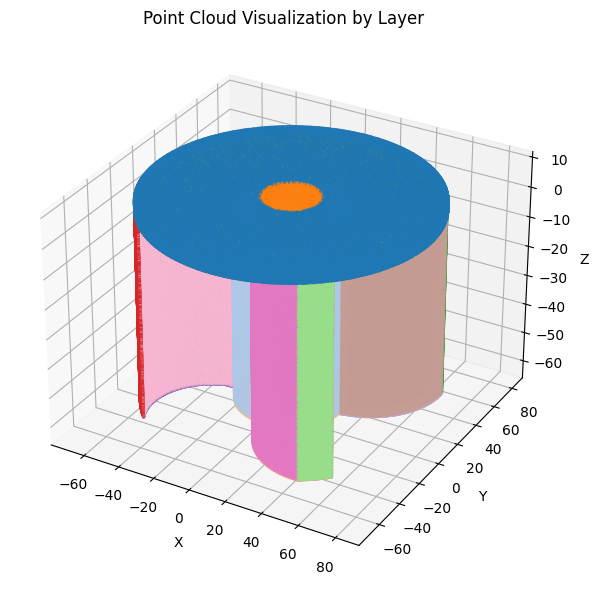

In [9]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt

def load_xyzc(path):
    data = np.loadtxt(path)
    if data.shape[1] != 4:
        raise ValueError("Input file must have 4 columns: x, y, z, label")
    return data

def print_layer_distribution(label_array):
    total = len(label_array)
    label_counts = Counter(label_array)
    print("📊 Layer distribution (by percentage):")
    for label, count in sorted(label_counts.items()):
        percent = 100.0 * count / total
        print(f"  Layer {label:.6f}: {count} points ({percent:.2f}%)")
    print("")

def visualize_point_cloud(data):
    x, y, z, label = data[:,0], data[:,1], data[:,2], data[:,3]
    print_layer_distribution(label)

    unique_labels = np.unique(label)
    label_to_color = {l: plt.cm.tab20(i / max(len(unique_labels)-1, 1)) 
                      for i, l in enumerate(unique_labels)}
    colors = np.array([label_to_color[l] for l in label])

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=colors, s=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Point Cloud Visualization by Layer')
    plt.tight_layout()
    plt.show()

# Load and visualize merged point cloud
merged_xyzc_path = output_file  # already defined in your notebook
data = load_xyzc(merged_xyzc_path)
visualize_point_cloud(data)

여기부터는 모델 학습

In [ ]:
#!/usr/bin/env python3
# 3번 서버의 point2cad/generate_segmentation_impeller0804_2.py 파일을 기반으로 작성되었습니다.

import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from src.PointNet_seg import PointNetSeg

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, logits, targets):
        logpt = -self.ce(logits, targets)
        pt = torch.exp(logpt)
        focal_loss = -((1 - pt) ** self.gamma) * logpt
        return focal_loss.mean()

def set_seed(seed=42):
    import random, os, torch, numpy as np
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- 1) FocalLoss (포인트별) ---
import torch.nn.functional as F
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.register_buffer("weight", weight if weight is not None else None)

    def forward(self, logits_NC, targets_N):
        # logits: [N, C], targets: [N]
        ce = F.cross_entropy(logits_NC, targets_N, weight=self.weight, reduction='none')  # [N]
        logp = -ce                                                        # [N]
        # pt = P(y_true) = softmax(logits)[range(N), targets]
        pt = F.softmax(logits_NC, dim=1)[torch.arange(targets_N.size(0), device=targets_N.device), targets_N]  # [N]
        loss = ((1 - pt).pow(self.gamma)) * ce                            # [N]
        return loss.mean()

# --- 2) 모델 I/O 규약 보조 유틸 ---
def forward_logits_NC(model, points_N3, device):
    """
    points_N3: torch.FloatTensor [N,3]
    PointNetSeg 가정: 입력 [B,3,N] -> 출력 [B,C,N]
    반환: logits_NC [N,C]
    """
    x = points_N3.T.unsqueeze(0).to(device)   # [1,3,N]
    out = model(x)                             # [1,C,N] (가정)
    logits_NC = out.squeeze(0).permute(1, 0)   # -> [N,C]
    return logits_NC

# --- 3) 전체/밸리드 청크 평가 ---
@torch.no_grad()
def eval_loss_metrics(model, pts_np, lbl_np, criterion, device, chunk=200_000):
    model.eval()
    N = pts_np.shape[0]
    total_loss, total_correct, total = 0.0, 0, 0
    for s in range(0, N, chunk):
        e = min(N, s+chunk)
        pts = torch.from_numpy(pts_np[s:e]).float().to(device)    # [M,3]
        y   = torch.from_numpy(lbl_np[s:e]).long().to(device)     # [M]
        logits = forward_logits_NC(model, pts, device)            # [M,C]
        loss = criterion(logits, y).item()
        pred = logits.argmax(dim=1)                               # [M]
        total_loss += loss * (e - s)
        total_correct += (pred == y).sum().item()
        total += (e - s)
    return total_loss/total, total_correct/total

# --- 4) 학습 루프 일부 교체 ---
def train_impeller(xyzc_path, model_out, lr, stop_loss, device, sample_size, seed=42, val_ratio=0.1):
    set_seed(seed)
    print(f"[Train] Using device: {device}")
    data = np.loadtxt(xyzc_path).astype(np.float32)
    assert data.shape[1] >= 4, "xyzc 파일은 최소 4컬럼(x,y,z,c)이어야 합니다."
    points = data[:, :3]
    orig_labels = data[:, 3].astype(np.int64)

    unique_labels = np.unique(orig_labels)
    label_to_idx = {lbl: idx for idx, lbl in enumerate(unique_labels)}
    labels = np.array([label_to_idx[l] for l in orig_labels], dtype=np.int64)
    num_classes = len(unique_labels)

    # train/val split
    N = points.shape[0]
    idx_all = np.arange(N); np.random.shuffle(idx_all)
    cut = int(N*(1.0 - val_ratio))
    tr_idx, va_idx = idx_all[:cut], idx_all[cut:]
    pts_tr, y_tr = points[tr_idx], labels[tr_idx]
    pts_va, y_va = points[va_idx], labels[va_idx]

    # 클래스 가중치 (과도치 클램프)
    counts = np.bincount(y_tr, minlength=num_classes).astype(np.float32)
    inv_freq = 1.0 / (counts + 1e-6)
    weights = inv_freq / inv_freq.sum() * num_classes
    weights = np.clip(weights, 0.5, 5.0)  # 필요시 조절
    class_weights = torch.tensor(weights, dtype=torch.float32, device=device)

    model = PointNetSeg(num_classes=num_classes).to(device)
    criterion = FocalLoss(gamma=2.0, weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-6)

    best_loss, best_state = float('inf'), None
    full_loss_history = []

    steps_per_epoch = max(1, pts_tr.shape[0] // sample_size)

    for epoch in range(1, 201):
        model.train()
        cycle_loss = 0.0

        for _ in range(steps_per_epoch):
            idx = np.random.choice(pts_tr.shape[0], sample_size, replace=False)
            x_batch = torch.from_numpy(pts_tr[idx]).float().to(device)   # [B,3] 아님! [N,3]
            y_batch = torch.from_numpy(y_tr[idx]).long().to(device)
            optimizer.zero_grad()
            logits = forward_logits_NC(model, x_batch, device)           # [N,C]
            loss = criterion(logits, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            cycle_loss += loss.item()
        scheduler.step()
        avg_loss = cycle_loss / steps_per_epoch
        print(f"Epoch {epoch}/200  TrainLoss(batch-avg): {avg_loss:.6f}")

        # 10 에폭마다 val 평가(청크)
        if epoch % 10 == 0:
            val_loss, val_acc = eval_loss_metrics(model, pts_va, y_va, criterion, device)
            full_loss_history.append(val_loss)
            print(f"  [Val] loss={val_loss:.6f} acc={val_acc*100:.2f}%")

            # best 저장
            if val_loss < best_loss:
                best_loss = val_loss
                best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
                os.makedirs(os.path.dirname(model_out), exist_ok=True)
                torch.save({'state_dict': best_state, 'unique_labels': unique_labels.tolist()},
                           os.path.join(os.path.dirname(model_out), 'best_'+os.path.basename(model_out)))
                print(f"  [Best] ValLoss improved → {best_loss:.6f}")

            # early stop (val 기준, 최근 5회 평가)
            if len(full_loss_history) >= 5 and all(l <= stop_loss for l in full_loss_history[-5:]):
                print(f"  [EarlyStop] last 5 ValLoss ≤ {stop_loss}")
                break

    # 최종 저장 (가드)
    if best_state is None:
        best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
    os.makedirs(os.path.dirname(model_out), exist_ok=True)
    torch.save({'state_dict': best_state, 'unique_labels': unique_labels.tolist()}, model_out)
    print(f"[Saved] Model → {model_out}  (best_val_loss={best_loss:.6f})")

    # 곡선 저장
    plt.figure()
    plt.plot(full_loss_history, marker='o')
    plt.title('Val Loss History (per 10 epochs)')
    plt.xlabel('Eval #'); plt.ylabel('Loss'); plt.grid(True)
    plt.savefig('full_loss_curve.png'); print("Loss curve → full_loss_curve.png")

# --- 5) 추론(청크 + 안전한 경로) ---
@torch.no_grad()
def infer_impeller(xyz_path, model_path, device, chunk=300_000):
    print(f"[Infer] Using {device}")
    data = np.loadtxt(xyz_path).astype(np.float32)
    assert data.shape[1] >= 3, "xyz 파일은 최소 3컬럼(x,y,z)이어야 합니다."
    points = data[:, :3]
    chk = torch.load(model_path, map_location=device)
    inv_map = {i: l for i, l in enumerate(chk['unique_labels'])}
    num_classes = len(chk['unique_labels'])

    model = PointNetSeg(num_classes=num_classes).to(device)
    model.load_state_dict(chk['state_dict']); model.eval()

    N = points.shape[0]
    preds = np.empty(N, dtype=np.int64)
    for s in range(0, N, chunk):
        e = min(N, s+chunk)
        pts = torch.from_numpy(points[s:e]).float().to(device)  # [M,3]
        logits = forward_logits_NC(model, pts, device)          # [M,C]
        preds[s:e] = logits.argmax(dim=1).cpu().numpy()

    out = np.hstack([points, np.array([inv_map[i] for i in preds], dtype=np.float32)[:, None]])
    base, ext = os.path.splitext(xyz_path)
    out_path = base + '_impeller_pred.xyzc'
    np.savetxt(out_path, out, fmt='%.6f')
    print(f"Saved → {out_path}")

    
if __name__=='__main__':
    p=argparse.ArgumentParser()
    p.add_argument('mode',choices=['train','infer'])
    p.add_argument('--xyzc_path',type=str); p.add_argument('--xyz_path',type=str)
    p.add_argument('--model_out',type=str,default='./models/impeller_seg.pth')
    p.add_argument('--model_path',type=str)
    p.add_argument('--lr',type=float,default=1e-4)
    p.add_argument('--stop_loss',type=float,default=0.1)
    p.add_argument('--batch_size',type=int,default=2000)
    args=p.parse_args()
    dev=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"GPUs: {torch.cuda.device_count()}, Using: {dev}")
    if args.mode=='train':
        assert args.xyzc_path, 'need --xyzc_path'
        train_impeller(args.xyzc_path,args.model_out,args.lr,args.stop_loss,dev,args.batch_size)
    else:
        assert args.model_path and args.xyz_path, 'need --model_path/--xyz_path'
        infer_impeller(args.xyz_path,args.model_path,dev)

# ===== Jupyter/CLI 겸용 러너 (하단 실행부) =====
import argparse
import torch
from types import SimpleNamespace

def _in_notebook():
    try:
        from IPython import get_ipython
        return get_ipython() is not None
    except Exception:
        return False

def main_cli_or_notebook(cfg: dict | None = None):
    """
    노트북: cfg 딕셔너리 필수 (argparse 미사용)
    CLI   : argparse 사용 (python script.py train --xyzc_path ... )
    """
    if _in_notebook():
        if cfg is None:
            raise RuntimeError("Notebook에서는 cfg=dict 를 넘겨주세요.")
        args = SimpleNamespace(**cfg)
    else:
        p = argparse.ArgumentParser()
        p.add_argument('mode', choices=['train', 'infer'])
        p.add_argument('--xyzc_path', type=str)
        p.add_argument('--xyz_path', type=str)
        p.add_argument('--model_out', type=str, default='./models/impeller_seg.pth')
        p.add_argument('--model_path', type=str)
        p.add_argument('--lr', type=float, default=1e-4)
        p.add_argument('--stop_loss', type=float, default=0.1)
        p.add_argument('--batch_size', type=int, default=2000)
        p.add_argument('--device', type=str, default=None)  # 'cuda', 'cuda:0', 'cpu'
        args = p.parse_args()

    # 디바이스
    dev = torch.device(args.device) if getattr(args, 'device', None) \
          else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"GPUs: {torch.cuda.device_count()}, Using: {dev}")

    if args.mode == 'train':
        assert args.xyzc_path, 'need xyzc_path'
        train_impeller(args.xyzc_path, args.model_out, args.lr, args.stop_loss, dev, args.batch_size)
    else:
        assert args.model_path and args.xyz_path, 'need model_path/xyz_path'
        infer_impeller(args.xyz_path, args.model_path, dev)

# ===== (노트북) 실행 예시 — 들여쓰기 없이 셀 맨 왼쪽에서 호출 =====
cfg = {
    'mode': 'train',
    'xyzc_path': r'C:\Users\user\Documents\GitHub\Ai_coding_study\point2cad\assets\ply\impeller\4wings\merged_all.xyzc',
    'model_out': './models/impeller_seg0821.pth',
    'lr': 1e-4,
    'stop_loss': 0.1,
    'batch_size': 2000,
    'device': None,  # 'cuda', 'cuda:0', 'cpu' 중 선택. None이면 자동
}
main_cli_or_notebook(cfg)

cfg = {
    'mode': 'infer',
    'xyz_path': r'C:\Users\user\Documents\GitHub\Ai_coding_study\point2cad\assets\ply\impeller\4wings\points.xyz',
    'model_path': './models/impeller_seg0821.pth',
    'device': None,  # or 'cpu'
}
main_cli_or_notebook(cfg)



IndentationError: unexpected indent (1058368201.py, line 298)

In [ ]:
# ==== Jupyter 한 셀에서 모두 해결 ====
# 1) 필수 임포트
import os, sys
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  # <- Pylance 'optim' undefined 해결

from scipy.spatial import cKDTree
from scipy.stats import mode

def normalize_points(points):
    # (N,3) → 원점 기준, 단위 스케일
    c = points.mean(0)
    p = points - c
    s = np.max(np.linalg.norm(p, axis=1))
    p = p / (s + 1e-8)
    return p.astype(np.float32), (c, s)

# 인덱스 보존형 증강(라벨 손실 없음): jitter/작은 회전/이동/스케일
def aug_index_preserving(p, jitter_sigma=0.002, jitter_clip=0.01,
                         rot_deg=2, trans_mag=0.005, scale_jitter=0.02):
    q = p.copy()
    # jitter
    n = np.clip(np.random.normal(0, jitter_sigma, q.shape), -jitter_clip, jitter_clip)
    q += n
    # small rotation (z축 예시; 필요시 x/y도 추가)
    th = np.deg2rad(np.random.uniform(-rot_deg, rot_deg))
    c, s = np.cos(th), np.sin(th)
    Rz = np.array([[c,-s,0],[s,c,0],[0,0,1]], np.float32)
    q = (q @ Rz.T).astype(np.float32)
    # small translation
    t = np.random.uniform(-trans_mag, trans_mag, (1,3)).astype(np.float32)
    q = q + t
    # small scaling
    sc = 1.0 + np.random.uniform(-scale_jitter, scale_jitter)
    q = q * sc
    return q

def knn_smooth(points, preds, k=16):
    k = int(min(k, len(points)))
    idx = cKDTree(points).query(points, k=k)[1]
    smoothed = mode(preds[idx], axis=1, keepdims=False).mode
    return np.asarray(smoothed, dtype=preds.dtype)



In [ ]:

SRC_ROOT = os.path.abspath(".")  # 예: 프로젝트 루트
if SRC_ROOT not in sys.path:
    sys.path.append(SRC_ROOT)

try:
    # 보통 파일 경로는 src/PointNet_seg.py 형태
    from src.PointNet_seg import PointNetSeg  # <- Pylance 'PointNetSeg' undefined 해결
except Exception as e:
    raise ImportError(
        "PointNetSeg를 import하지 못했습니다. "
        "노트북 작업 디렉토리 기준으로 'src/PointNet_seg.py'가 있는지 확인하고, "
        "경로가 다르면 SRC_ROOT를 맞춰주세요."
    ) from e
# 3) FocalLoss 정의 (학습 스크립트와 동일/호환)
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(weight=weight, reduction='none')

    def forward(self, logits, targets):
        # logits: (B,C) 또는 (N,C) 형태, targets: (B,) 또는 (N,)
        ce = self.ce(logits, targets)             # (N,)
        pt = torch.exp(-ce)                       # p = exp(-CE)
        loss = ((1 - pt) ** self.gamma) * ce      # focal
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

def train_impeller_robust(xyzc_path, model_out, lr, stop_loss, device, sample_size,
                          lambda_consis=0.5, epochs=200):
    print(f"[Train-Robust] Using device: {device}")
    data = np.loadtxt(xyzc_path).astype(np.float32)
    points = data[:, :3]
    orig_labels = data[:, 3].astype(np.int64)

    # 0) 정규화
    points, _ = normalize_points(points)

    # 1) 라벨 매핑
    unique_labels = np.unique(orig_labels)
    label_to_idx = {lbl: idx for idx, lbl in enumerate(unique_labels)}
    labels = np.array([label_to_idx[l] for l in orig_labels], dtype=np.int64)

    # 2) 모델/손실/옵티마이저
    num_classes = len(unique_labels)
    model = PointNetSeg(num_classes=num_classes).to(device)

    # class-imbalance 가중치(있으면 그대로 사용)
    counts = np.bincount(labels, minlength=num_classes)
    inv_freq = 1.0 / (counts + 1e-6)
    weights = inv_freq / np.sum(inv_freq) * num_classes
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

    # Focal + Consistency
    criterion_sup = FocalLoss(gamma=2.0, weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    best_loss = float('inf'); best_state = None; full_loss_history = []
    N = points.shape[0]; steps_per_epoch = max(1, N // sample_size)
    model.train()

    for epoch in range(1, epochs+1):
        cycle_loss = 0.0
        # 점진적 램프업(초반엔 감독 위주, 후반엔 일관성 비중 ↑)
        lam = lambda_consis * min(1.0, epoch / (epochs*0.3))

        for _ in range(steps_per_epoch):
            idx = np.random.choice(N, sample_size, replace=False)
            x_clean = points[idx]          # (B,3)
            y_batch = labels[idx]          # (B,)

            # 인덱스 유지하는 증강만 사용(라벨 매칭 깨지지 않도록)
            x_aug = aug_index_preserving(x_clean)

            x_clean_t = torch.from_numpy(x_clean.T).unsqueeze(0).to(device)  # (1,3,B)
            x_aug_t   = torch.from_numpy(x_aug.T).unsqueeze(0).to(device)
            y_t       = torch.from_numpy(y_batch).to(device)

            optimizer.zero_grad()
            logits_clean = model(x_clean_t).squeeze(0).permute(1,0)  # (B,C)
            logits_aug   = model(x_aug_t).squeeze(0).permute(1,0)    # (B,C)

            # train 루프 내부
            loss_sup = criterion_sup(logits_clean, y_t)

            beta = 0.2  # 0.1~0.3 권장
            loss_sup_aug = criterion_sup(logits_aug, y_t)

            p_clean = F.softmax(logits_clean, dim=1)
            p_aug   = F.softmax(logits_aug,   dim=1)
            loss_cons = F.mse_loss(p_clean, p_aug)

            loss = loss_sup + beta*loss_sup_aug + lam*loss_cons

            loss.backward(); optimizer.step()
            cycle_loss += float(loss.item())

        avg_loss = cycle_loss / steps_per_epoch
        scheduler.step()
        print(f"Epoch {epoch}/{epochs}  Loss: {avg_loss:.6f}  (sup={loss_sup.item():.6f}, cons={loss_cons.item():.6f}, lam={lam:.3f})")

        # 10epoch마다 full-loss(정규화된 전체 포인트 기준)
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                x_full = torch.from_numpy(points.T).unsqueeze(0).to(device)
                y_full = torch.from_numpy(labels).to(device)
                logits_full = model(x_full).squeeze(0).permute(1,0)
                full_loss = criterion_sup(logits_full, y_full).item()
            model.train()
            full_loss_history.append(full_loss)
            print(f"  FullLoss: {full_loss:.6f}")

            if full_loss < best_loss:
                best_loss = full_loss; best_state = model.state_dict()
                save_dir = os.path.dirname(model_out) or "."
                os.makedirs(save_dir, exist_ok=True)
                torch.save({'state_dict': best_state, 'unique_labels': unique_labels.tolist()},
                           os.path.join(save_dir, 'best_'+os.path.basename(model_out)))
                print(f"  [Best] FullLoss improved → {best_loss:.6f}")

            # 간단 early stop (원하면 검증 셋 분리 추천)
            if len(full_loss_history)>=5 and all(l <= stop_loss for l in full_loss_history[-5:]):
                print(f"  [EarlyStop] last 5 FullLoss ≤ {stop_loss}")
                break

    # 최종 저장
    os.makedirs(os.path.dirname(model_out), exist_ok=True)
    final_state = best_state if best_state is not None else model.state_dict()
    torch.save({'state_dict': final_state,
                'unique_labels': unique_labels.tolist()}, model_out)
    print(f"[Saved] Model → {model_out}  (best_loss={best_loss:.6f})")


In [ ]:
def infer_impeller_robust(xyz_path, model_path, device, tta=5, knn_k=16,
                          small_jitter=0.001, small_rot_deg=2, small_trans=0.003):
    print(f"[Infer-Robust] Using {device}")
    data = np.loadtxt(xyz_path).astype(np.float32)
    orig_points = data[:, :3]                         # 원본 보관
    points, (c, s) = normalize_points(orig_points)    # 정규화

    

    # 모델 로드
    chk = torch.load(model_path, map_location=device)
    inv_map = {i:l for i,l in enumerate(chk['unique_labels'])}
    num_classes = len(chk['unique_labels'])
    model = PointNetSeg(num_classes=num_classes).to(device)
    model.load_state_dict(chk['state_dict']); model.eval()

    # TTA: 작은 노이즈/회전/이동 여러 번 → 확률 평균
    with torch.no_grad():
        acc_probs = None
        for _ in range(tta):
            p_aug = aug_index_preserving(points,
                                         jitter_sigma=small_jitter, jitter_clip=3*small_jitter,
                                         rot_deg=small_rot_deg, trans_mag=small_trans, scale_jitter=0.0)
            x = torch.from_numpy(p_aug.T).unsqueeze(0).to(device)
            logits = model(x).squeeze(0)          # (C,N)
            probs = torch.softmax(logits, dim=0)  # (C,N)
            acc_probs = probs if acc_probs is None else (acc_probs + probs)
        probs_avg = acc_probs / float(tta)
        preds = probs_avg.argmax(dim=0).cpu().numpy()

    # KNN 스무딩
    preds = knn_smooth(points, preds, k=knn_k)

    # 저장 (원본 스케일 좌표를 쓰고 싶으면 정규화 이전 좌표 따로 보관하세요)
    out_xyz = points * s + c                          # 복원!
    out = np.hstack([out_xyz, np.array([inv_map[int(i)] for i in preds])[:, None]])
    out_path = xyz_path.replace('.xyz','_impeller_pred.xyzc')
    np.savetxt(out_path, out, fmt='%.6f'); print(f"Saved → {out_path}")
    return out_path


In [ ]:
# Train
train_impeller_robust(
    xyzc_path="../assets/ply/impeller/3wings/impeller_b3_merged_all.xyzc",
    model_out="./models/impeller_seg_robust_b3.pth",
    lr=1e-4, stop_loss=0.001,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    sample_size=2000,
    lambda_consis=0.2, epochs=2000
)

# Infer
infer_impeller_robust(
    xyz_path="C:\\Users\\user\\Documents\\GitHub\\Ai_coding_study\\point2cad\\assets\\xyz\\Impeller_b3_gpu.xyz",
    model_path="./models/impeller_seg_robust_b3.pth",
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    tta=5, knn_k=16
)



In [ ]:
# ==== Jupyter 한 셀에서 모두 해결 (Robust PointNetSeg) ====
# 필수 임포트
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.spatial import cKDTree
from scipy.stats import mode

# ------------------------------------------------------------
# 유틸
# ------------------------------------------------------------
def normalize_points(points: np.ndarray):
    """(N,3) → 원점 기준 단위 스케일 정규화, (정규화된 점, (중심, 스케일)) 반환"""
    c = points.mean(0)
    p = points - c
    s = np.max(np.linalg.norm(p, axis=1))
    p = p / (s + 1e-8)
    return p.astype(np.float32), (c, s)

def aug_index_preserving(p: np.ndarray,
                         jitter_sigma=0.002, jitter_clip=0.01,
                         rot_deg=2.0, trans_mag=0.005, scale_jitter=0.02):
    """인덱스 보존형 증강(라벨 손실 없음)"""
    q = p.copy()
    # jitter
    n = np.clip(np.random.normal(0, jitter_sigma, q.shape), -jitter_clip, jitter_clip)
    q += n
    # small rotation (z축, 필요 시 x/y도 추가 가능)
    th = np.deg2rad(np.random.uniform(-rot_deg, rot_deg))
    c, s = np.cos(th), np.sin(th)
    Rz = np.array([[c,-s,0],[s,c,0],[0,0,1]], np.float32)
    q = (q @ Rz.T).astype(np.float32)
    # small translation
    t = np.random.uniform(-trans_mag, trans_mag, (1,3)).astype(np.float32)
    q = q + t
    # small scaling
    sc = 1.0 + np.random.uniform(-scale_jitter, scale_jitter)
    q = q * sc
    return q

def knn_smooth(points: np.ndarray, preds: np.ndarray, k=16):
    """KNN 다수결 라벨 스무딩"""
    k = int(min(k, len(points)))
    idx = cKDTree(points).query(points, k=k)[1]
    smoothed = mode(preds[idx], axis=1, keepdims=False).mode
    return np.asarray(smoothed, dtype=preds.dtype)

# ------------------------------------------------------------
# 모델 임포트
# ------------------------------------------------------------
SRC_ROOT = os.path.abspath(".")  # 예: 프로젝트 루트
if SRC_ROOT not in sys.path:
    sys.path.append(SRC_ROOT)

try:
    # 보통 파일 경로는 src/PointNet_seg.py 형태
    from src.PointNet_seg import PointNetSeg
except Exception as e:
    raise ImportError(
        "PointNetSeg를 import하지 못했습니다. "
        "노트북 작업 디렉토리 기준으로 'src/PointNet_seg.py'가 있는지 확인하고, "
        "경로가 다르면 SRC_ROOT를 맞춰주세요."
    ) from e

# ------------------------------------------------------------
# 손실 정의
# ------------------------------------------------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(weight=weight, reduction='none')

    def forward(self, logits, targets):
        # logits: (N,C), targets: (N,)
        ce = self.ce(logits, targets)             # (N,)
        pt = torch.exp(-ce)                       # p = exp(-CE)
        loss = ((1 - pt) ** self.gamma) * ce      # focal
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

# ------------------------------------------------------------
# (옵션) EMA Teacher & KL 일관성
# ------------------------------------------------------------
import copy
def create_ema(model):
    ema = copy.deepcopy(model).eval()
    for p in ema.parameters():
        p.requires_grad_(False)
    return ema

@torch.no_grad()
def update_ema(student, teacher, mu=0.999):
    for ps, pt in zip(student.parameters(), teacher.parameters()):
        pt.data.mul_(mu).add_(ps.data, alpha=1-mu)

# ------------------------------------------------------------
# 학습 루틴
# ------------------------------------------------------------
def train_impeller_robust(xyzc_path,
                          model_out="./models/impeller_seg_robust.pth",
                          lr=1e-4, stop_loss=0.001,
                          device=None,
                          sample_size=2000,
                          lambda_consis=0.2,   # 일관성 손실 가중치(최대)
                          beta_aug=0.2,        # 증강 배치 감독 가중치
                          epochs=2000,
                          use_label_smoothing=False, label_smoothing=0.05,
                          use_ema_kld=False, ema_mu=0.999, cons_temp=2.0,
                          save_curve=True):
    """
    - 증강 배치에도 감독 손실 추가(beta_aug)
    - 일관성 손실 램프업(lambda_consis * min(1, epoch/(epochs*0.3)))
    - (옵션) EMA teacher + KL 일관성
    - CosineAnnealingLR 스케줄
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"[Train-Robust] Using device: {device}")

    # 데이터 로드
    data = np.loadtxt(xyzc_path).astype(np.float32)
    points = data[:, :3]
    orig_labels = data[:, 3].astype(np.int64)

    # 정규화
    points, _ = normalize_points(points)

    # 라벨 인덱스화
    unique_labels = np.unique(orig_labels)
    label_to_idx = {lbl: idx for idx, lbl in enumerate(unique_labels)}
    labels = np.array([label_to_idx[l] for l in orig_labels], dtype=np.int64)

    # 모델/손실/옵티마이저
    num_classes = len(unique_labels)
    model = PointNetSeg(num_classes=num_classes).to(device)

    # 클래스 불균형 가중치
    counts = np.bincount(labels, minlength=num_classes)
    inv_freq = 1.0 / (counts + 1e-6)
    weights = inv_freq / np.sum(inv_freq) * num_classes
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

    # 감독 손실 선택
    if use_label_smoothing:
        criterion_sup = nn.CrossEntropyLoss(weight=class_weights,
                                            label_smoothing=label_smoothing)
    else:
        criterion_sup = FocalLoss(gamma=2.0, weight=class_weights)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    # (옵션) EMA teacher
    ema_model = create_ema(model) if use_ema_kld else None

    best_loss = float('inf')
    best_state = None
    full_loss_history = []

    N = points.shape[0]
    steps_per_epoch = max(1, int(np.ceil(N / max(1, sample_size))))

    model.train()
    for epoch in range(1, epochs + 1):
        cycle_loss = 0.0
        # 일관성 램프업 (초반 30% 구간)
        lam = lambda_consis * min(1.0, epoch / (epochs * 0.3))

        # (선택) 후반부 약간 완화
        if epoch > 0.8 * epochs:
            lam *= 0.5

        # 증강 강도도 후반에 살짝 감소
        cur_sigma = float(np.interp(epoch, [1, 0.7*epochs, epochs],
                                    [0.002, 0.002, 0.001]))
        cur_rot   = float(np.interp(epoch, [1, 0.7*epochs, epochs],
                                    [2.0,   2.0,   1.0  ]))
        cur_trans = 0.003  # 고정 (필요시 스케줄링)

        for _ in range(steps_per_epoch):
            # 샘플링 (데이터가 sample_size보다 적으면 replace=True)
            replace_flag = sample_size > N
            idx = np.random.choice(N, sample_size, replace=replace_flag)
            x_clean = points[idx]      # (B,3)
            y_batch = labels[idx]      # (B,)

            # 인덱스 보존 증강
            x_aug = aug_index_preserving(
                x_clean,
                jitter_sigma=cur_sigma, jitter_clip=3*cur_sigma,
                rot_deg=cur_rot, trans_mag=cur_trans, scale_jitter=0.01
            )

            x_clean_t = torch.from_numpy(x_clean.T).unsqueeze(0).to(device)  # (1,3,B)
            x_aug_t   = torch.from_numpy(x_aug.T).unsqueeze(0).to(device)
            y_t       = torch.from_numpy(y_batch).to(device)

            optimizer.zero_grad()

            # forward
            logits_clean = model(x_clean_t).squeeze(0).permute(1, 0)  # (B,C)
            logits_aug   = model(x_aug_t).squeeze(0).permute(1, 0)    # (B,C)

            # 감독 손실 (clean)
            loss_sup = criterion_sup(logits_clean, y_t)

            # 증강 배치 감독(약하게)
            loss_sup_aug = criterion_sup(logits_aug, y_t) if beta_aug > 0 else 0.0

            # 일관성 손실
            if use_ema_kld:
                # EMA teacher KL( student||teacher )
                with torch.no_grad():
                    t_logits = ema_model(x_aug_t).squeeze(0).permute(1,0) / cons_temp
                    t_prob   = F.softmax(t_logits, dim=1)
                s_logits = logits_aug / cons_temp
                log_prob = F.log_softmax(s_logits, dim=1)
                loss_cons = F.kl_div(log_prob, t_prob, reduction='batchmean') * (cons_temp * cons_temp)
            else:
                # 단순 MSE(consistency)
                p_clean = F.softmax(logits_clean, dim=1)
                p_aug   = F.softmax(logits_aug,   dim=1)
                loss_cons = F.mse_loss(p_clean, p_aug)

            # 총손실
            if isinstance(loss_sup_aug, float):
                loss = loss_sup + lam * loss_cons
            else:
                loss = loss_sup + beta_aug * loss_sup_aug + lam * loss_cons

            loss.backward()
            optimizer.step()

            # EMA 업데이트
            if ema_model is not None:
                update_ema(model, ema_model, mu=ema_mu)

            cycle_loss += float(loss.item())

        avg_loss = cycle_loss / steps_per_epoch
        scheduler.step()
        # 모니터링: 마지막 스텝의 loss 항들 출력 (대표값)
        cons_val = float(loss_cons.detach().cpu()) if torch.is_tensor(loss_cons) else float(loss_cons)
        print(f"Epoch {epoch}/{epochs}  Loss: {avg_loss:.6f}  (sup={float(loss_sup.detach().cpu()):.6f}, cons={cons_val:.6f}, lam={lam:.3f})")

        # 10 epoch마다 전체 평가(정규화 좌표 기준)
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                x_full = torch.from_numpy(points.T).unsqueeze(0).to(device)
                y_full = torch.from_numpy(labels).to(device)
                logits_full = model(x_full).squeeze(0).permute(1,0)
                full_loss = criterion_sup(logits_full, y_full).item()
            model.train()

            full_loss_history.append(full_loss)
            print(f"  FullLoss: {full_loss:.6f}")

            # best 저장
            save_dir = os.path.dirname(model_out) or "."
            os.makedirs(save_dir, exist_ok=True)
            if full_loss < best_loss:
                best_loss = full_loss
                best_state = model.state_dict()
                torch.save({'state_dict': best_state, 'unique_labels': unique_labels.tolist()},
                           os.path.join(save_dir, 'best_'+os.path.basename(model_out)))
                print(f"  [Best] FullLoss improved → {best_loss:.6f}")

            # 간단 early stop
            if len(full_loss_history) >= 5 and all(l <= stop_loss for l in full_loss_history[-5:]):
                print(f"  [EarlyStop] last 5 FullLoss ≤ {stop_loss}")
                break

    # 최종 저장
    os.makedirs(os.path.dirname(model_out) or ".", exist_ok=True)
    final_state = best_state if best_state is not None else model.state_dict()
    torch.save({'state_dict': final_state, 'unique_labels': unique_labels.tolist()}, model_out)
    print(f"[Saved] Model → {model_out}  (best_loss={best_loss:.6f})")

    # Loss curve 저장(옵션)
    if save_curve and len(full_loss_history) > 0:
        plt.figure(figsize=(6,4))
        plt.plot(full_loss_history, marker='o')
        plt.title('Full Loss History (every 10 epochs)')
        plt.xlabel('Eval # (x10 epochs)')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)
        curve_path = os.path.join(os.path.dirname(model_out) or ".", "full_loss_curve.png")
        plt.savefig(curve_path, dpi=150, bbox_inches="tight")
        print(f"[Saved] Loss curve → {curve_path}")

# ------------------------------------------------------------
# 추론 루틴
# ------------------------------------------------------------
def infer_impeller_robust(xyz_path, model_path, device=None,
                          tta=5, knn_k=16,
                          small_jitter=0.001, small_rot_deg=2, small_trans=0.003):
    """
    - 입력 xyz를 정규화 → TTA(작은 증강 여러 번) 확률 평균 → KNN 스무딩 → 원본 스케일 복원 → xyzc 저장
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"[Infer-Robust] Using {device}")

    data = np.loadtxt(xyz_path).astype(np.float32)
    orig_points = data[:, :3]
    points, (c, s) = normalize_points(orig_points)  # 정규화 (한 번만)

    # 모델 로드
    chk = torch.load(model_path, map_location=device)
    inv_map = {i: l for i, l in enumerate(chk['unique_labels'])}
    num_classes = len(chk['unique_labels'])
    model = PointNetSeg(num_classes=num_classes).to(device)
    model.load_state_dict(chk['state_dict'])
    model.eval()

    # TTA: 작은 노이즈/회전/이동 여러 번 → 확률 평균
    with torch.no_grad():
        acc_probs = None
        for _ in range(tta):
            p_aug = aug_index_preserving(points,
                                         jitter_sigma=small_jitter, jitter_clip=3*small_jitter,
                                         rot_deg=small_rot_deg, trans_mag=small_trans, scale_jitter=0.0)
            x = torch.from_numpy(p_aug.T).unsqueeze(0).to(device)  # (1,3,N)
            logits = model(x).squeeze(0)          # (C,N)
            probs = torch.softmax(logits, dim=0)  # (C,N)
            acc_probs = probs if acc_probs is None else (acc_probs + probs)
        probs_avg = acc_probs / float(tta)
        preds = probs_avg.argmax(dim=0).cpu().numpy()

    # KNN 스무딩(정규화 좌표에서)
    preds = knn_smooth(points, preds, k=knn_k)

    # 원본 스케일 복원
    out_xyz = points * s + c
    out = np.hstack([out_xyz, np.array([inv_map[int(i)] for i in preds])[:, None]])
    out_path = xyz_path.replace('.xyz', '_impeller_pred.xyzc')
    np.savetxt(out_path, out, fmt='%.6f')
    print(f"[Saved] → {out_path}")
    return out_path

# ------------------------------------------------------------
# 사용 예시 (경로/파라미터는 상황에 맞게 수정)
# ------------------------------------------------------------
if __name__ == "__main__":
    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Train
    train_impeller_robust(
        xyzc_path="../assets/ply/impeller/3wings/impeller_b3_merged_all.xyzc",
        model_out="./models/impeller_seg_robust_b3.pth",
        lr=1e-4, stop_loss=0.001,
        device=dev,
        sample_size=2000,
        lambda_consis=0.2,   # 일관성 가중치
        beta_aug=0.2,        # 증강 배치 감독 가중치
        epochs=2000,
        use_label_smoothing=False,  # True로 바꾸면 CE + label smoothing 사용
        label_smoothing=0.05,
        use_ema_kld=False,   # True로 바꾸면 EMA Teacher + KL 일관성 사용
        ema_mu=0.999, cons_temp=2.0,
        save_curve=True
    )

    # Infer
    infer_impeller_robust(
        xyz_path=r"C:\Users\user\Documents\GitHub\Ai_coding_study\point2cad\assets\xyz\Impeller_b3_gpu.xyz",
        model_path="./models/impeller_seg_robust_b3.pth",
        device=dev,
        tta=5, knn_k=16,
        small_jitter=0.001, small_rot_deg=2, small_trans=0.003
    )
